# Tutorial 5.1: Logistic regression and Gaussian Processes

Welcome to the fifth tutorial of the course 'Machine learning for Precision Medicine'.

In this exercise, we want to predict benign and malignant breast cancer from biopsy images with a logistic regression model. We herefore use the WDBC dataset containing 
- 569 samples from patients with known diagnosis
- 357 benign
- 212 malignant
- 30 features extracted from fine needle aspirate slides

We are given a number of features that describe the cell nuclei that have been determined from image processing techniques [Street et al, 1992].

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import util

For this exercise, we have outsourced some functions, which we frequently use in a second python script 'util.py'. 

In [2]:
#load the data with the load_data() function in util.py
X_train, y_train = util.load_data('data.csv')
X_test, y_test = util.load_data('data.csv', testing_data=True)

In [3]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,bias
249,-0.740508,-1.014519,-0.745503,-0.707013,0.351537,-0.497685,-0.571494,-0.506314,0.260609,-0.158433,...,-0.730716,-0.785787,-0.683447,0.286310,-0.611108,-0.440357,-0.282091,-0.383019,-0.324505,1.0
58,-0.305966,0.004736,-0.385500,-0.363161,-1.121587,-1.259344,-1.106185,-1.154336,0.026949,-1.103975,...,-0.558102,-0.506991,-0.450875,-1.326851,-1.223647,-1.296979,-1.575895,-0.747019,-1.166825,1.0
476,0.020650,0.288638,0.018164,-0.103779,-0.501736,0.122408,-0.479215,-0.473040,-1.115796,-0.383832,...,0.257745,0.144127,-0.091558,-0.748217,0.563842,-0.100693,0.293779,-0.593330,-0.297351,1.0
529,-0.584300,-1.361252,-0.582390,-0.596377,0.970677,-0.270077,-0.640169,-0.540104,-0.564504,0.465313,...,-1.613330,-0.605880,-0.581312,0.864944,-0.579301,-0.527672,-0.619360,-0.193738,-0.189844,1.0
422,-0.714947,-0.760869,-0.680010,-0.701609,0.885278,0.236117,-0.223847,-0.101864,0.271562,0.057043,...,-0.978239,-0.754511,-0.711749,0.400283,-0.237058,-0.201441,-0.062524,-0.184032,-0.536193,1.0


In [19]:
# y_train = y_train.replace({"M" : 1, "B" : 0})
# y_test = y_test.replace({"M" : 1, "B" : 0})

In [4]:
y_train[0:20] # 1 where malignant, 0 otherwise

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0.])

### Binary Classification

**Classification** refers to the task of predicting a **class label** $y$, *i.e.*, the diagnosis, from a **feature vector** $\bf{x}$.
For the case, where $y$ can take one of two values, we speak of binary classification.


For the task at hand, this means that for the image features, we are
then given a new image for which we don't know the diagnosis. We can predict the diagnosis based on what we have learned from from the training data.

Similar to linear regression, we are trying to find an optimal weight vector $\mathbf{w}$ that will minize our objective function. However, we have to make adjustments because we are no longer dealing with continous output variables, but binary class labels. In most real-world datasets, the two classes will not be perfectly separable, i.e. we expect to make mistakes and want to minimize those. Therefore we predict probabilities of belonging to class 1, instead of binary class labels. We can achieve this by making use of the logistic sigmoid link function. 

The **logistic** $\pi(a)$ is a function between 0 and 1, making it suited for modeling probabilities. It is called a **sigmoid** function because of its *s*-shape.

\begin{equation}
\pi(a) := \frac{1}{1+\exp{\left(-a\right)}} = \frac{\exp{\left(a\right)}}{1+\exp{\left(a\right)}}
\end{equation}

Here, as we are modeling linear functions, $a=\mathbf{x}_n\mathbf{w}$, where $\mathbf{x}_n$ is the **feature vector** for the $n$-th individual (given), and $\mathbf{w}$ is a **weight vector** that we would like to find.


## Task 1: ##  
Implement the logistic sigmoid following the formula above. We have to make sure that the output of this function is never exactly 0 or 1, because we will take the log of it. Therefore, we use np.clip() to limit range (from ... to).

In [5]:
def logistic(a):
    logist = np.clip(np.exp(a) / (1 + np.exp(a)), 1e-10, 1-1e-10)
    return logist

As in every machine learning problem, we need to define an **objective** function $L$. It quantifies the error between our predictions and the ground-truth. We then determine the weights $\mathbf{w}^{opt}$ that minimize $L$.

We would like to assign high probability to all the instances that belong to the target class and low probability otherwise. Accordingly, we would like to obtain a function that records a loss, whenever we assign low probability to the correct class $c_{true}$.

One function that achieves this is the **log-loss** or **cross-entropy** loss, which is defined as:

\begin{equation}
loss = -\sum_{n\in c_1} \ln( \pi(\mathbf{x}_n\mathbf{w}) ) - \sum_{n'\in c_2} \ln( 1-\pi(\mathbf{x}_{n'}\mathbf{w}) )
\end{equation}


Where $c_1$ are all the members of the first class (here: malignant, `y == 1.`) and $c_2$ are all the members of the second class (benign, `y == 0.`).

## Task 2:
Implement the log-loss (binary cross entropy function) using the formula above. 

In [6]:
def logloss(y, y_hat):
    """
    return the loss for predicted probabilities y_hat, and class labels y
    Keyworld arguments
    y -- scalar or numpy array
    y_hat -- scalar or numpy array
    """
    loss = np.sum(y * np.log(y_hat)) * -1 - (np.sum((1- y) * (np.log(1 - y_hat))))
    
    return loss
    

In [7]:
logloss(np.array([0.,1.,1.]), np.array([0.1, 0.5, 0.99]))

0.8085580320712731

** Expected output **:
0.80855803207127308

Taken together, we obtain the **Logistic Regression objective** $L(\mathbf{w})$.
\begin{equation}
L(\mathbf{w}) = \underbrace{-\sum_{n\in c_1} \ln( \pi(\mathbf{x}_n\mathbf{w}) ) - \sum_{n'\in c_2} \ln( 1-\pi(\mathbf{x}_{n'}\mathbf{w}) )}_{loss} + \underbrace{ \lambda \cdot 0.5 \cdot \sum_{d=1}^{D}{w_d}^2}_{regularizer}
\end{equation}

## Task 3:  
Implement the regularizer

In [8]:
def regularizer(w, lambd):
    '''
    return the value for the regularizer for a given w and lamd
    ''' 
    reg = lambd * 0.5 * np.sum(np.square(w))
    return reg

### The derivative

In order to minimize our objective function, we will make use of the derivative. The derivative will tell us in which direction we have to adjust our weights, in order to minimize the loss. Note that no analytical solition exists. Instead, we will have to optimize our objective using an optimization algorithm (see below). The derivative of the objective with respect to a single $w_d$ is defined as follows:

\begin{equation}
\frac{\partial L}{\partial w_d} = \sum_n^{N}{x_{nd}} \cdot
 \left( \pi\left(\mathbf{x}_n\mathbf{w}_n\right)-I\left(\mathbf{y}_n== c_1\right)\right) + \lambda \cdot w_d
\end{equation}

With $I$ being the Identity matrix. $I(a==b)$ denotes the indicator function, which yields 1 if $a=b$ and 0 otherwise.

The sign of the derivative indicates the direction in which the objective gets larger or smaller and the magnitude the rate.

### The gradient

By stacking all partial derivatives into a single vector, we obtain the gradient $\nabla_\mathbf{w} (L)$.

\begin{equation}
\nabla{L}\left(\mathbf{w}^{t}\right) =
\left[\begin{matrix}
\frac{\partial L}{\partial w^t_1}\\
\vdots\\
\frac{\partial L}{\partial w^t_D}
\end{matrix}\right]
=
\underbrace{\mathbf{X}^{T}
 \left( \pi\left(\mathbf{X}\mathbf{w}^t\right)-I\left(\mathbf{y}==c_1\right)\right)}_{\nabla{\text{loss}}\left(\mathbf{w}^{t}\right)}+ \underbrace{\lambda \cdot \mathbf{w}^t}_{\nabla{\text{regularizer}}\left(\mathbf{w}^{t}\right)}
\end{equation}

$\nabla_\mathbf{w} (L)$ is a $D$-dimensional vector pointing in the direction of steepest growth of the objective and in the opposite direction in which the steepest reduction.
Using the gradient, we can define a simple optimization algorithm.

#### Steepest descent

The steepest descent algorithm uses the gradient by making small steps in the direction $-\nabla_{\mathbf{w}^{t}} (L)$. You can think about it as being on a hill and descending the hill in the steepest direction downwards.
Therefore the algorithm is called **steepest descent**.

given learning rate $0<\alpha<1.0$ and current weight estimate $\mathbf{w}^{t}$.
Iterate by setting $\mathbf{w}^{t+1} = \mathbf{w}^{t} - \alpha \cdot \nabla_{\mathbf{w}^{t}} (L)$.

A typical value for $\alpha$ is around $10^{-4}$.

A problem with steepest descent is that the estimate tends to oscillate and often even overshoots and diverges (leading to an increase in the objective). Getting the learning rate right is very hard, trading off progress in learning and risk of diverging. Many tricks exit to improve learning in gradient descent, such as weight decay, where the learning rate is gradually reduced during learning.

Here we will implement the steepest_descent_optimizer as a class, which has the attributes: alpha, lamd, X, y, w and max_iter (maximum number of iterations) and the functions: predict(), optimize()

## Task 4:

We will now implement the algorithm described above using a class Steepest_descent_optimizer(). 

You are given the template below, and are expected to complete the methods `_gradient()`, `_update()` and `optimize()`.

Remember within the class you can access the current weights, X, y, value for the regularizer (`lambd`), etc using `self.w`, `self.X`, `self.y` and so on.

The `_gradient()` method should use `self.X`, `self.y`, `self.w`, `self.lambd` ($\lambda$) the `logistic()` function you implemented above, and return the gradient of the loss function with respect to `self.w` ($\mathbf{w}$) (see formula above for $\nabla{L}\left(\mathbf{w}^{t}\right)$). Tip: for $(y == c_1)$ you can just use `self.y` directly.

The `_update()` method should get the gradient using `self._gradient()` and update the current weights `self.w` using the learning rate (`self.alpha`) and the update rule for steepest descent described above: $\mathbf{w}^{t+1} = \mathbf{w}^{t} - \alpha \cdot \nabla_{\mathbf{w}^{t}} (L)$

Finally, the `optimize()` function will update the weights for `self.max_iter` times, and after every update calculate the loss (including the regularizer) and store it in a list `loss`. Finally, it returns this `loss`-"history".


In [9]:
class Steepest_descent_optimizer():
    
    def __init__(self,X,y,lambd,alpha):
        self.alpha = alpha
        self.lambd = lambd
        
        self.X = X
        self.y = y
        
        self.w = np.zeros(X.shape[1]) # we initialize the weights with zeros
        
        self.max_iter = 10000 # set the max number of iterations
    
    def _gradient(self):
        grad = np.transpose(self.X).dot(self.predict(self.X) - self.y) + self.lambd * self.w
        return grad
    
    def _update(self):
        grad = self._gradient()
        self.w =  self.w - self.alpha * grad
        
    def predict(self, X):
        return logistic(X.dot(self.w))
        
    def optimize(self):
        it = 0
        loss = []
        # we iterate until we reach self.max_iter
        while it < self.max_iter:
            # update the weights (use the method you implemented above)
            # append the current loss (use self.predict, and the regularizer(), and logloss() functions)
            # your_code
            y_hat = self.predict(self.X)
            loss.append(logloss(self.y, y_hat) + regularizer(self.w, self.lambd))
            self._update()
            it += 1
        return loss

In [10]:
# Create an instance of the class
optimizer = Steepest_descent_optimizer(X_train, y_train, lambd = 0.001, alpha = 0.001)

# run the optimization for 10000 steps, this might take a while...
loss = optimizer.optimize()

In [11]:
optimizer.w

radius_mean               -0.218132
texture_mean              -0.502005
perimeter_mean            -0.222728
area_mean                  0.108349
smoothness_mean            0.179280
compactness_mean          -1.660805
concavity_mean             1.392011
concave points_mean        1.922669
symmetry_mean             -0.067893
fractal_dimension_mean    -0.950538
radius_se                  3.927088
texture_se                -0.002377
perimeter_se               0.784866
area_se                    2.937028
smoothness_se              0.614444
compactness_se            -2.116729
concavity_se               0.572643
concave points_se          2.430675
symmetry_se               -0.665005
fractal_dimension_se      -3.291730
radius_worst               2.416222
texture_worst              2.849129
perimeter_worst            1.972269
area_worst                 2.669299
smoothness_worst          -0.286017
compactness_worst          0.308261
concavity_worst            0.691145
concave points_worst       1

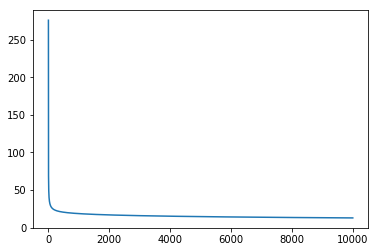

In [12]:
# Plot  the evolution of the loss
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss)),np.array(loss))

In [13]:
# Predict from the test set
test_pred = optimizer.predict(X_test)

In [14]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [15]:
import importlib
importlib.reload(util)

<module 'util' from 'C:\\Users\\Lasse 2\\Desktop\\ml4pm\\ex05\\util.py'>

Let's see how accurate our predictions are using the average precision score and the roc area under the curve score.

In [16]:
average_precision_score(y_test, test_pred)

0.9933530740531429

** Expected output **:  ~ 0.993

In [17]:
roc_auc_score(y_test, test_pred)

0.9957378012933569

** Expected output **: ~ 0.995

number samples: 171
number M: 63.0
number B: 108
Sensitivity: 0.968
Specificity: 0.924


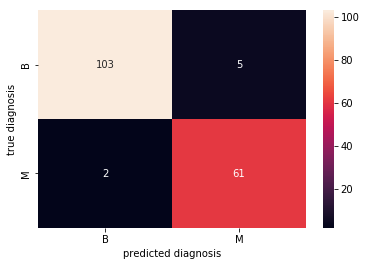

In [18]:
util.plot_confusion_matrix(test_pred, y_test)

Congratulations, you made it through one part of the fifth tutorial of this course!

# Submitting your assignment

Please rename your notebook under your full name and **submit it on the moodle platform**. If you have problems to do so, you can also send it again to machinelearning.dhc@gmail.com

Please rename the file to 1_LinRegTut_<GROUP\>.ipynb and replace <GROUP\> with your group-name.

As this is also the first time for us preparing this tutorial, you are welcome to give us feedback to help us improve this tutorial.  

Thank you!  

Jana & Remo